In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch import nn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torchvision.models as models


In [3]:
tr_folder = os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training')
labels = []
file = []

for classes in tr_folder:
    files = os.listdir('/kaggle/input/brain-tumor-mri-dataset/Training/' + classes)
    for f in files:
        file.append(classes + '/' + f)
        labels.append(classes)

train_df = pd.DataFrame({"Images":file, "Label":labels})

In [4]:
train_df


,Images,Label
0,pituitary/Tr-pi_0532.jpg,pituitary
1,pituitary/Tr-pi_0282.jpg,pituitary
2,pituitary/Tr-pi_1401.jpg,pituitary
3,pituitary/Tr-pi_0914.jpg,pituitary
4,pituitary/Tr-pi_0691.jpg,pituitary
...,...,...
5707,glioma/Tr-gl_0578.jpg,glioma
5708,glioma/Tr-gl_0659.jpg,glioma
5709,glioma/Tr-gl_0253.jpg,glioma
5710,glioma/Tr-gl_0492.jpg,glioma


In [5]:
# make labels for test set
ts_folder = os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing')
labels = []
file = []

for classes in tr_folder:
    files = os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing/' + classes)
    for f in files:
        file.append(classes + '/' + f)
        labels.append(classes)

test_df = pd.DataFrame({"Images":file, "Label":labels})

In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)

        # Ensure the image has three channels (RGB)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=10),  # Randomly rotate the image by a certain degree
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

# Define the validation/test transformation without data augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])


In [8]:
NUM_EPOCHS = 20
BATCH_SIZE =32
NUM_CLASSES = 4
classes = ('glioma', 'meningioma', 'notumor', 'pituitary') 

In [9]:
# Splitting train_df into training and validation sets
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [10]:
# Create datasets
train_dataset = BrainTumorDataset(train_df, root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=val_transform)
valid_dataset = BrainTumorDataset(valid_df, root_dir='/kaggle/input/brain-tumor-mri-dataset/Training', transform=val_transform)
test_dataset = BrainTumorDataset(test_df, root_dir='/kaggle/input/brain-tumor-mri-dataset/Testing', transform=val_transform)


In [11]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader =DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


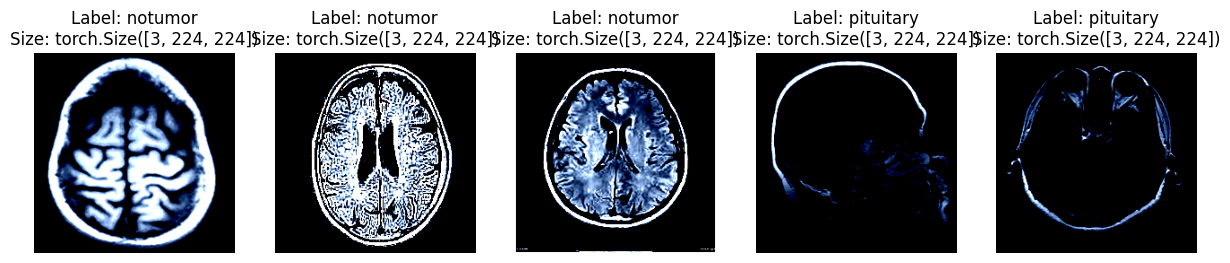

In [12]:
# Get some random samples from the training dataset
num_samples = 5
random_indices = np.random.randint(0, len(train_dataset), num_samples)

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image, label = train_dataset[idx]
    image_size = image.size()  # Get the size of the image
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}\nSize: {image_size}")
    axes[i].axis('off')

plt.show()

In [13]:
train_df

,Images,Label
4695,glioma/Tr-gl_0597.jpg,glioma
4489,glioma/Tr-gl_1314.jpg,glioma
219,pituitary/Tr-pi_0885.jpg,pituitary
2843,notumor/Tr-no_0404.jpg,notumor
1115,pituitary/Tr-pi_1251.jpg,pituitary
...,...,...
3772,meningioma/Tr-me_1044.jpg,meningioma
5191,glioma/Tr-gl_1255.jpg,glioma
5226,glioma/Tr-gl_0783.jpg,glioma
5390,glioma/Tr-gl_0969.jpg,glioma


In [14]:

# label mapping for brain tumor
class_to_idx = {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary':3}

# Apply the mapping to convert labels to numerical format
train_df['Label'] = train_df['Label'].map(class_to_idx)
valid_df['Label'] = valid_df['Label'].map(class_to_idx)
test_df['Label'] = test_df['Label'].map(class_to_idx)



In [15]:
tr_labels = torch.tensor(train_df['Label'].values)
val_labels =torch.tensor(valid_df['Label'].values)
ts_labels = torch.tensor(test_df['Label'].values)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Basic CNN


In [17]:
from torch import nn 


class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), 
            nn.Dropout(0.2) ,
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2) ,
            

        )
        # Calculate the input size of the linear layer dynamically
        self.fc_input_size = hidden_units * 56 * 56
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.fc_input_size,
                      out_features=output_shape),
            #nn.Dropout(0.5) ,
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        # Flatten the output
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
MyCNN = CNN(input_shape=3, 
            hidden_units=128, 
            output_shape=4)
MyCNN.to(device) 




CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=4, bias=True)
  )
)

In [18]:
#Setting loss and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=MyCNN.parameters(), lr=0.0001, weight_decay=0.001)

In [19]:
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = MyCNN(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Print accuracy and loss at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Training - Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Validation
    MyCNN.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = MyCNN(images)
            val_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation accuracy and loss at the end of each epoch
    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation - Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

[1,   100] loss: 0.798
Training - Epoch [1/20], Loss: 0.1547, Accuracy: 72.16%
Validation - Epoch [1/20], Loss: 0.5938, Accuracy: 78.13%
[2,   100] loss: 0.428
Training - Epoch [2/20], Loss: 0.0964, Accuracy: 85.05%
Validation - Epoch [2/20], Loss: 0.4458, Accuracy: 83.38%
[3,   100] loss: 0.250
Training - Epoch [3/20], Loss: 0.0538, Accuracy: 91.79%
Validation - Epoch [3/20], Loss: 0.5254, Accuracy: 83.73%
[4,   100] loss: 0.170
Training - Epoch [4/20], Loss: 0.0300, Accuracy: 94.66%
Validation - Epoch [4/20], Loss: 0.4600, Accuracy: 86.26%
[5,   100] loss: 0.109
Training - Epoch [5/20], Loss: 0.0295, Accuracy: 96.15%
Validation - Epoch [5/20], Loss: 0.6915, Accuracy: 83.90%
[6,   100] loss: 0.089
Training - Epoch [6/20], Loss: 0.0116, Accuracy: 97.59%
Validation - Epoch [6/20], Loss: 0.5140, Accuracy: 88.98%
[7,   100] loss: 0.055
Training - Epoch [7/20], Loss: 0.0100, Accuracy: 98.38%
Validation - Epoch [7/20], Loss: 0.4927, Accuracy: 88.98%
[8,   100] loss: 0.044
Training - Epoch [

In [20]:
# Save the trained model
torch.save(MyCNN, 'MyCNN.pth')
print('Finished Training. Model saved ')

Finished Training. Model saved 


### resnet 18 

In [21]:

from torchvision.models import resnet18


# Load pre-trained ResNet-18 model
resnet = resnet18(pretrained=True)

# Replace the last fully connected layer with a new one
num_ftrs = resnet.fc.in_features
num_classes = 4  # Replace 4 with the number of classes in your dataset
resnet.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Print accuracy and loss at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Validation
    resnet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = resnet(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation accuracy and loss at the end of each epoch
    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   100] loss: 0.537
Training - Epoch [1/20], Loss: 0.0720, Accuracy: 83.78%
Validation - Epoch [1/20], Loss: 0.1946, Accuracy: 93.79%
[2,   100] loss: 0.265
Training - Epoch [2/20], Loss: 0.0505, Accuracy: 91.07%
Validation - Epoch [2/20], Loss: 0.1401, Accuracy: 95.19%
[3,   100] loss: 0.137
Training - Epoch [3/20], Loss: 0.0214, Accuracy: 95.62%
Validation - Epoch [3/20], Loss: 0.1666, Accuracy: 94.66%
[4,   100] loss: 0.082
Training - Epoch [4/20], Loss: 0.0146, Accuracy: 97.55%
Validation - Epoch [4/20], Loss: 0.1540, Accuracy: 95.19%
[5,   100] loss: 0.077
Training - Epoch [5/20], Loss: 0.0090, Accuracy: 97.81%
Validation - Epoch [5/20], Loss: 0.1912, Accuracy: 94.23%
[6,   100] loss: 0.026
Training - Epoch [6/20], Loss: 0.0057, Accuracy: 99.04%
Validation - Epoch [6/20], Loss: 0.1414, Accuracy: 94.84%
[7,   100] loss: 0.020
Training - Epoch [7/20], Loss: 0.0041, Accuracy: 99.39%
Validation - Epoch [7/20], Loss: 0.1295, Accuracy: 95.54%
[8,   100] loss: 0.012
Training - Epoch [

In [22]:
# Save the trained model
torch.save(resnet, 'resnet18_trained.pth')
print('Finished Training. Model saved ')

Finished Training. Model saved 


### resnet 34 

In [23]:
from torchvision.models import resnet34
# Load pre-trained ResNet-34 model
resnet34_model = resnet34(pretrained=True)

# Replace the last fully connected layer with a new one
num_ftrs = resnet34_model.fc.in_features
num_classes = 4  # Replace 4 with the number of classes in your dataset
resnet34_model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet34_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 20  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = resnet34_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Print accuracy and loss at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Validation
    resnet34_model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = resnet34_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation accuracy and loss at the end of each epoch
    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   100] loss: 0.498
Training - Epoch [1/20], Loss: 0.0629, Accuracy: 85.03%
Validation - Epoch [1/20], Loss: 0.1849, Accuracy: 93.35%
[2,   100] loss: 0.277
Training - Epoch [2/20], Loss: 0.0520, Accuracy: 91.42%
Validation - Epoch [2/20], Loss: 0.3054, Accuracy: 87.93%
[3,   100] loss: 0.131
Training - Epoch [3/20], Loss: 0.0220, Accuracy: 95.69%
Validation - Epoch [3/20], Loss: 0.1713, Accuracy: 93.00%
[4,   100] loss: 0.112
Training - Epoch [4/20], Loss: 0.0291, Accuracy: 96.06%
Validation - Epoch [4/20], Loss: 0.2167, Accuracy: 92.30%
[5,   100] loss: 0.074
Training - Epoch [5/20], Loss: 0.0101, Accuracy: 97.92%
Validation - Epoch [5/20], Loss: 0.1456, Accuracy: 95.19%
[6,   100] loss: 0.035
Training - Epoch [6/20], Loss: 0.0090, Accuracy: 98.69%
Validation - Epoch [6/20], Loss: 0.0928, Accuracy: 97.11%
[7,   100] loss: 0.032
Training - Epoch [7/20], Loss: 0.0073, Accuracy: 98.91%
Validation - Epoch [7/20], Loss: 0.1188, Accuracy: 96.06%
[8,   100] loss: 0.008
Training - Epoch [

In [24]:
# Save the trained model
torch.save(resnet34, 'resnet34_trained.pth')
print('Finished Training. Model saved ')

Finished Training. Model saved 


### VGG 16


In [25]:

from torchvision.models import vgg16

# Load pre-trained VGG16 model
vgg16_model = vgg16(pretrained=True)

# Replace the fully connected layer with a new one
num_ftrs = vgg16_model.classifier[6].in_features
num_classes = 4  # Replace 4 with the number of classes in your dataset
vgg16_model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 20  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Print accuracy and loss at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Validation
    vgg16_model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = vgg16_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation accuracy and loss at the end of each epoch
    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 175MB/s]  


[1,   100] loss: 0.519
Training - Epoch [1/20], Loss: 0.0797, Accuracy: 82.56%
Validation - Epoch [1/20], Loss: 0.2026, Accuracy: 92.65%
[2,   100] loss: 0.160
Training - Epoch [2/20], Loss: 0.0325, Accuracy: 94.79%
Validation - Epoch [2/20], Loss: 0.1867, Accuracy: 93.79%
[3,   100] loss: 0.069
Training - Epoch [3/20], Loss: 0.0146, Accuracy: 97.70%
Validation - Epoch [3/20], Loss: 0.1036, Accuracy: 96.68%
[4,   100] loss: 0.066
Training - Epoch [4/20], Loss: 0.0058, Accuracy: 98.27%
Validation - Epoch [4/20], Loss: 0.0848, Accuracy: 97.46%
[5,   100] loss: 0.025
Training - Epoch [5/20], Loss: 0.0025, Accuracy: 99.41%
Validation - Epoch [5/20], Loss: 0.0984, Accuracy: 97.38%
[6,   100] loss: 0.005
Training - Epoch [6/20], Loss: 0.0016, Accuracy: 99.87%
Validation - Epoch [6/20], Loss: 0.1000, Accuracy: 97.38%
[7,   100] loss: 0.003
Training - Epoch [7/20], Loss: 0.0005, Accuracy: 99.91%
Validation - Epoch [7/20], Loss: 0.0978, Accuracy: 97.55%
[8,   100] loss: 0.011
Training - Epoch [

In [26]:
# Save the trained model
torch.save(vgg16_model, 'vgg16_trained.pth')
print('Finished Training. Model saved as vgg16_cifar10.pth')

Finished Training. Model saved as vgg16_cifar10.pth


### VGG19

In [27]:

from torchvision.models import vgg19
# Load pre-trained VGG19 model
vgg19_model = vgg19(pretrained=True)

# Replace the fully connected layer with a new one
num_ftrs = vgg19_model.classifier[6].in_features
num_classes = 4  # Replace 4 with the number of classes in your dataset
vgg19_model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19_model.parameters(), lr=0.001, momentum=0.9)

# Train the model
num_epochs = 20  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU

        optimizer.zero_grad()

        outputs = vgg19_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:  # Print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Print accuracy and loss at the end of each epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    # Validation
    vgg19_model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = vgg19_model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation accuracy and loss at the end of each epoch
    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct_val / total_val
    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 162MB/s]  


[1,   100] loss: 0.524
Training - Epoch [1/20], Loss: 0.0844, Accuracy: 82.05%
Validation - Epoch [1/20], Loss: 0.2249, Accuracy: 91.51%
[2,   100] loss: 0.186
Training - Epoch [2/20], Loss: 0.0399, Accuracy: 93.89%
Validation - Epoch [2/20], Loss: 0.1559, Accuracy: 94.31%
[3,   100] loss: 0.085
Training - Epoch [3/20], Loss: 0.0121, Accuracy: 97.40%
Validation - Epoch [3/20], Loss: 0.1753, Accuracy: 94.14%
[4,   100] loss: 0.057
Training - Epoch [4/20], Loss: 0.0092, Accuracy: 98.21%
Validation - Epoch [4/20], Loss: 0.1865, Accuracy: 94.66%
[5,   100] loss: 0.057
Training - Epoch [5/20], Loss: 0.0050, Accuracy: 98.56%
Validation - Epoch [5/20], Loss: 0.1137, Accuracy: 96.06%
[6,   100] loss: 0.016
Training - Epoch [6/20], Loss: 0.0056, Accuracy: 99.39%
Validation - Epoch [6/20], Loss: 0.0989, Accuracy: 96.68%
[7,   100] loss: 0.007
Training - Epoch [7/20], Loss: 0.0035, Accuracy: 99.74%
Validation - Epoch [7/20], Loss: 0.0953, Accuracy: 97.38%
[8,   100] loss: 0.004
Training - Epoch [

In [28]:
# Save the trained model
torch.save(vgg19_model, 'vgg19_trained.pth')
print('Finished Training. Model saved ')

Finished Training. Model saved 


### AlexNet

The model is trained other notebook 

In [29]:
alexnet_model = torch.load('/kaggle/input/alexnet/pytorch/braintumor_alexnet/1/alexnet_main.pth')

ResNet18: Accuracy=98.78%, Loss=0.0423, Time=9.35 seconds
ResNet34: Accuracy=99.08%, Loss=0.0398, Time=8.10 seconds
VGG16: Accuracy=98.02%, Loss=0.0761, Time=11.93 seconds
VGG19: Accuracy=98.25%, Loss=0.0583, Time=14.19 seconds
AlexNet: Accuracy=95.19%, Loss=0.1334, Time=7.55 seconds
MyCNN: Accuracy=92.07%, Loss=0.4337, Time=11.04 seconds


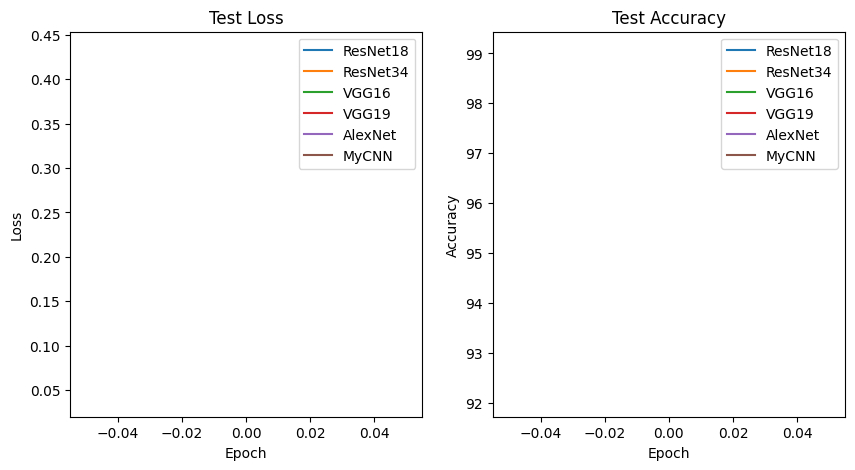

In [39]:

# Define a function to evaluate model on test loader
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device  # Get the device of the model
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()  # Start measuring time
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)  # Move input data to the same device as the model
            labels = labels.to(device)  # Move labels to the same device as the model
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    loss = test_loss / len(test_loader)
    end_time = time.time()  # End measuring time
    elapsed_time = end_time - start_time  # Calculate elapsed time
    return accuracy, loss, elapsed_time


# Define your models
models_list = [
    {"name": "ResNet18", "model": resnet},
    {"name": "ResNet34", "model": resnet34_model},
    {"name": "VGG16", "model": vgg16_model},
    {"name": "VGG19", "model": vgg19_model},
    {"name": "AlexNet", "model": alexnet_model},
    {"name": "MyCNN", "model": MyCNN},
    
    # Add your MyCNN model here
    # {"name": "MyCNN", "model": MyCNN()}
]

# Evaluate models on the test loader
results = {"name": [], "accuracy": [], "loss": [], "time": []}
for model_info in models_list:
    model_name = model_info["name"]
    model = model_info["model"]
    accuracy, loss, elapsed_time = evaluate_model(model, test_loader)
    results["name"].append(model_name)
    results["accuracy"].append(accuracy)
    results["loss"].append(loss)
    results["time"].append(elapsed_time)
    print(f"{model_name}: Accuracy={accuracy:.2f}%, Loss={loss:.4f}, Time={elapsed_time:.2f} seconds")
# Plot loss and accuracy curves for each model
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
for i, model_info in enumerate(models_list):
    model_name = model_info["name"]
    loss_curve = results["loss"][i]
    plt.plot(loss_curve, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i, model_info in enumerate(models_list):
    model_name = model_info["name"]
    accuracy_curve = results["accuracy"][i]
    plt.plot(accuracy_curve, label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.show()


